# 1. Load and transform the dataset<a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns
from scipy.ndimage.interpolation import shift
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from joblib import dump, load
from sklearn.decomposition import PCA
import pickle as pk

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
train_df = pd.read_csv(r"sign_mnist_train.csv")
test_df = pd.read_csv(r"sign_mnist_test.csv")

In [3]:
# Rename label into Label
train_df.rename(columns={'label':'Label'},inplace = True)
test_df.rename(columns={'label':'Label'},inplace = True)

# Shuffle
train_df = train_df.sample(frac = 1.0).reset_index(drop = True)
test_df = test_df.sample(frac = 1.0).reset_index(drop = True)

In [4]:
# Show the first lines
train_df.iloc[:4,:30]

,Label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29
0,19,163,162,162,163,163,162,160,160,160,...,150,148,147,146,144,144,143,141,140,164
1,17,115,118,124,129,134,139,141,143,148,...,163,162,162,162,160,159,159,158,158,117
2,22,84,79,66,83,71,29,45,65,72,...,102,120,146,149,148,149,154,157,158,87
3,0,168,171,174,175,177,180,182,184,186,...,192,191,193,194,193,192,192,191,191,170


In [5]:
printmd(f'### Number of images in the training set: {train_df.shape[0]}')
printmd(f'### Number of images in the test set: {test_df.shape[0]}')

d = int((train_df.shape[1] - 1)**0.5)
printmd(f'### Shape of the images: {d} x {d}')

### Number of images in the training set: 27455

### Number of images in the test set: 7172

### Shape of the images: 28 x 28

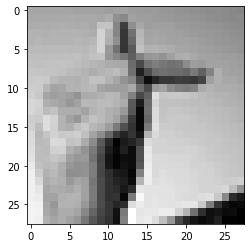

In [6]:
def to_image(array, label = True):
    # Reshape an array into an image format
    array = np.array(array)
    start_idx = 1 if label else 0
    return array[start_idx:].reshape(28,28).astype(float)
        
# Display one image
img = to_image(train_df.iloc[0])
plt.imshow(img, cmap = 'gray')
plt.show()

In [7]:
# The labels are coded in numbers. 
# Create a mapping to get the letters corresponding to the numbers
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {}

for i,l in enumerate(alphab):
    mapping_letter[l] = i
mapping_letter = {v:k for k,v in mapping_letter.items()}

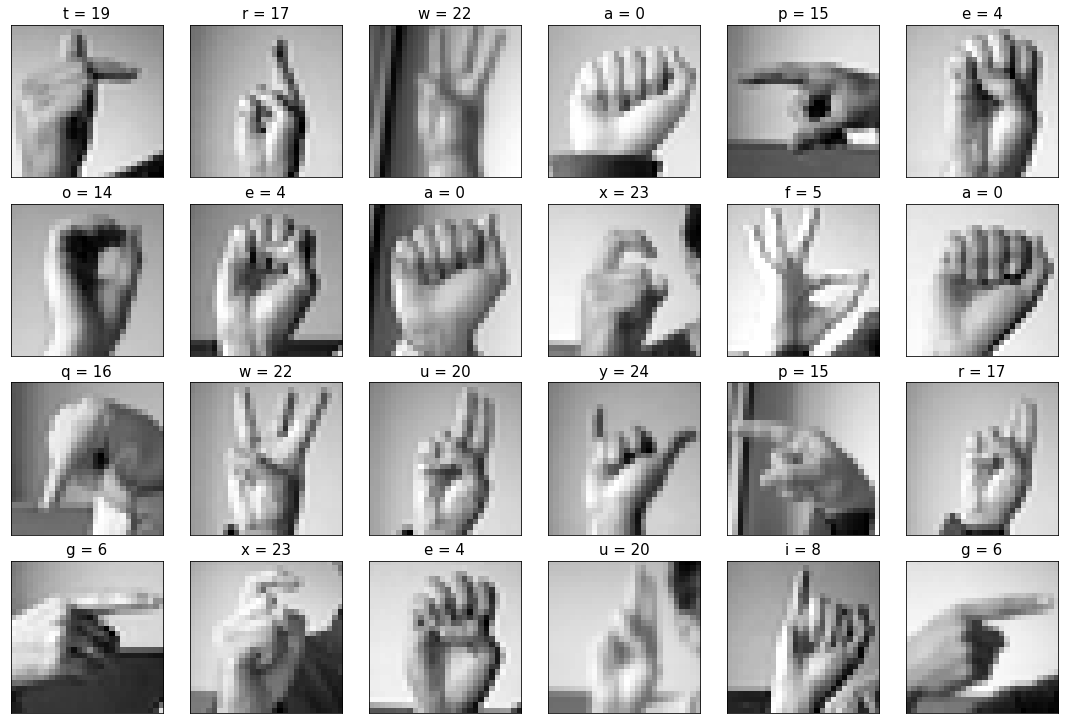

In [8]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = to_image(train_df.iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = mapping_letter[train_df.Label[i]] + " = " + str(train_df.Label[i])
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

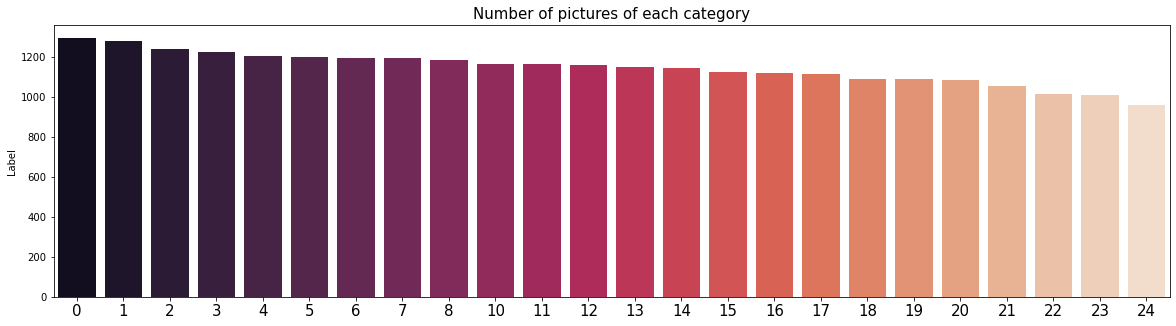

In [9]:
# Display the number of pictures of each letter
vc = train_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

# 2. Split the data and create the generator<a class="anchor" id="2"></a>

In [41]:
train_df_original = train_df.copy()

# Split into training, test and validation sets
val_index = int(train_df.shape[0]*0.1)
#10%
train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

y_train = train_df['Label']
y_val = val_df['Label']
y_test = test_df['Label']

# Reshape the traing and test set to use them with a generator
X_train = train_df.drop('Label',axis = 1).values.reshape(train_df.shape[0], 28, 28, 1)
X_val = val_df.drop('Label',axis = 1).values.reshape(val_df.shape[0], 28, 28, 1)
X_test = test_df.drop('Label',axis = 1).values.reshape(test_df.shape[0], 28, 28, 1)

In [53]:
# Display the shapes of the sets
X_train.shape, X_val.shape, X_test.shape

((22239, 28, 28, 1), (2471, 28, 28, 1), (7172, 28, 28, 1))

In [30]:
#using a cnn 
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Flatten(),
                    
                    Dense(units=1024, activation="relu"),                 
                    Dense(units=256, activation="relu"),
                    Dropout(0.5),
                    Dense(units=25, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 512)         590336    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [ ]:
#to augmente the data
def augmenteData(data,model):
    #for knn data is the images array
    #for cnn data is [x,y,batch_size]
    generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")

    photos = []
    if model == 'knn':
        augmentedX = generator.flow(X_train)
        augmentedY = generator.flow(y_train)
        augmentedImagesX = augmentedX[0]
        augmentedImagesY = augmentedY[0]
        for i in range(len(augmentedX)-1):
                augmentedImagesX = np.concatenate((augmentedImagesX,augmentedX[i]))
                augmentedImagesY = np.concatenate((augmentedImagesY,augmentedY[i]))
                
        return np.array(photos)
    elif model =='cnn':
        return generator.flow(data[0], data[1], batch_size=data[2])


In [33]:
X_train_flow = augmenteData([X_train, y_train,32],'cnn')
X_val_flow = augmenteData([X_val, y_val,32], batch_size=32,'cnn')
# X_test_flow = generator.flow(X_test, y_test)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow, 
                    validation_data=X_val_flow, 
                    epochs=100,
                    callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True), 
                        
                            learning_rate_reduction
                    ])

Epoch 1/100
773/773 [==============================] - 32s 40ms/step - loss: 1.7675 - accuracy: 0.4355 - val_loss: 0.4109 - val_accuracy: 0.8503
Epoch 2/100
773/773 [==============================] - 31s 40ms/step - loss: 0.3042 - accuracy: 0.8959 - val_loss: 0.0930 - val_accuracy: 0.9690
Epoch 3/100
773/773 [==============================] - 31s 40ms/step - loss: 0.1149 - accuracy: 0.9631 - val_loss: 0.0649 - val_accuracy: 0.9785
Epoch 4/100
773/773 [==============================] - 30s 39ms/step - loss: 0.0753 - accuracy: 0.9766 - val_loss: 0.0270 - val_accuracy: 0.9920
Epoch 5/100
773/773 [==============================] - 31s 40ms/step - loss: 0.0583 - accuracy: 0.9830 - val_loss: 0.0504 - val_accuracy: 0.9851
Epoch 6/100
773/773 [==============================] - 30s 39ms/step - loss: 0.0486 - accuracy: 0.9856 - val_loss: 0.0361 - val_accuracy: 0.9865

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
773/773 [============================

# 4. Visualize the result <a class="anchor" id="4"></a>

In [46]:
# Map the numbers into letters
y_test_letters = [mapping_letter[x] for x in y_test]
pred_letters_cnn = [mapping_letter[x] for x in pred]

In [34]:
# Predict the label of the test_images
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## {acc*100:.2f}% accuracy on the test set')

## 99.79% accuracy on the test set

In [47]:
print(classification_report(y_test_letters,pred_letters_cnn))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00       331
           b       1.00      0.99      1.00       432
           c       1.00      1.00      1.00       310
           d       1.00      1.00      1.00       245
           e       1.00      1.00      1.00       498
           f       0.98      1.00      0.99       247
           g       1.00      0.99      0.99       348
           h       1.00      1.00      1.00       436
           i       1.00      1.00      1.00       288
           k       1.00      1.00      1.00       331
           l       1.00      1.00      1.00       209
           m       1.00      1.00      1.00       394
           n       1.00      1.00      1.00       291
           o       1.00      1.00      1.00       246
           p       1.00      0.98      0.99       347
           q       0.96      1.00      0.98       164
           r       1.00      1.00      1.00       144
           s       1.00    

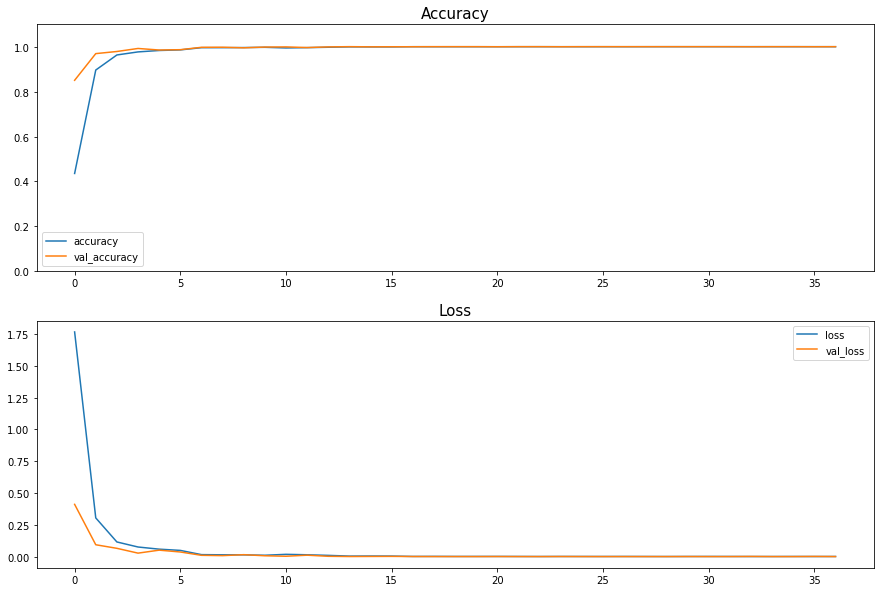

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

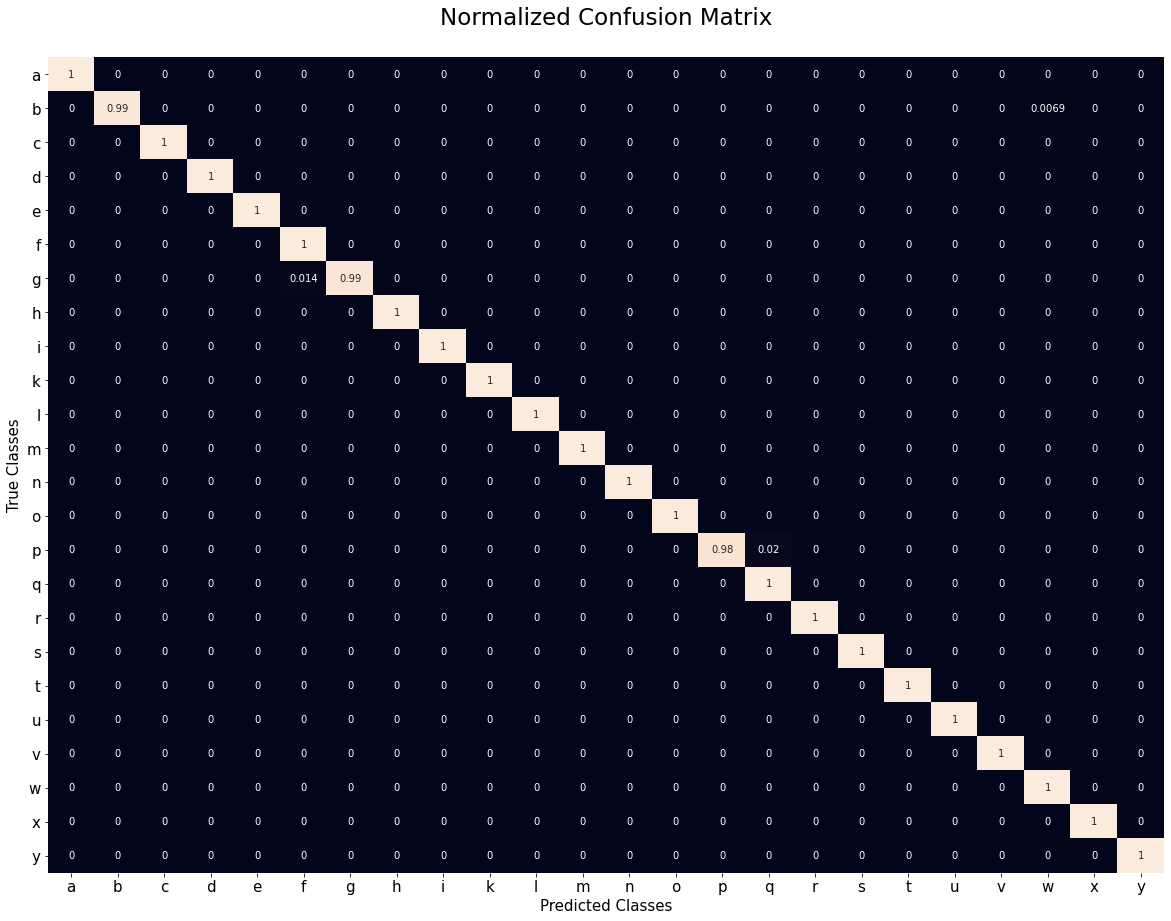

In [38]:
# Display a confusion matrix
cf_matrix = confusion_matrix(y_test_letters, pred_letters, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test_letters)), yticklabels = sorted(set(y_test_letters)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()